**TASK 3 : CUSTOMER SEGMENTATION/CLUSTERING**

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

data = transactions.merge(customers, on='CustomerID')

data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11


In [15]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

customer_transactions = transactions.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    transaction_count=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean'),
    total_quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
    first_transaction_date=pd.NamedAgg(column='TransactionDate', aggfunc='min'),
    last_transaction_date=pd.NamedAgg(column='TransactionDate', aggfunc='max'),
).reset_index()

customer_transactions['recency_days'] = (pd.Timestamp.now() - customer_transactions['last_transaction_date']).dt.days

customer_profile = pd.merge(customers, customer_transactions, on='CustomerID', how='inner')

In [16]:
numeric_features = [
    "total_spent",
    "transaction_count",
    "avg_transaction_value",
    "total_quantity",
    "recency_days",
]
data_for_clustering = customer_profile[numeric_features]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

In [17]:
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

In [18]:
for n_clusters, db_index, silhouette_avg in zip(cluster_range, db_scores, silhouette_scores):
    print(f"Number of Clusters: {n_clusters}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print("-" * 30)

Number of Clusters: 2
Davies-Bouldin Index: 1.1263
Silhouette Score: 0.3246
------------------------------
Number of Clusters: 3
Davies-Bouldin Index: 1.0163
Silhouette Score: 0.3354
------------------------------
Number of Clusters: 4
Davies-Bouldin Index: 1.0800
Silhouette Score: 0.3079
------------------------------
Number of Clusters: 5
Davies-Bouldin Index: 1.1101
Silhouette Score: 0.2814
------------------------------
Number of Clusters: 6
Davies-Bouldin Index: 1.0549
Silhouette Score: 0.2883
------------------------------
Number of Clusters: 7
Davies-Bouldin Index: 1.1068
Silhouette Score: 0.2584
------------------------------
Number of Clusters: 8
Davies-Bouldin Index: 1.1178
Silhouette Score: 0.2555
------------------------------
Number of Clusters: 9
Davies-Bouldin Index: 1.0496
Silhouette Score: 0.2603
------------------------------
Number of Clusters: 10
Davies-Bouldin Index: 1.1381
Silhouette Score: 0.2477
------------------------------


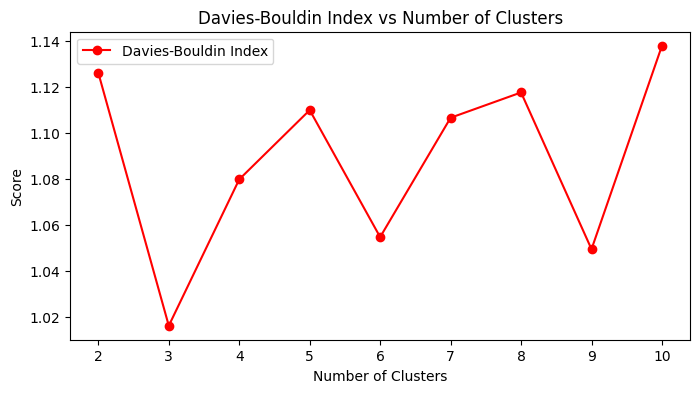

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, db_scores, marker='o', label='Davies-Bouldin Index', color ='r')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.legend()
plt.show()

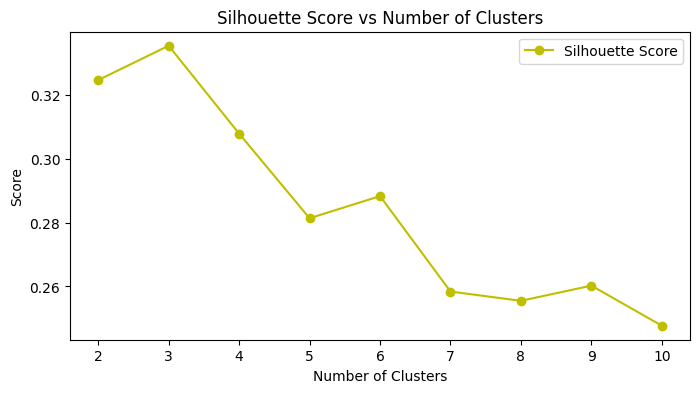

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score', color ='y')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.legend()
plt.show()

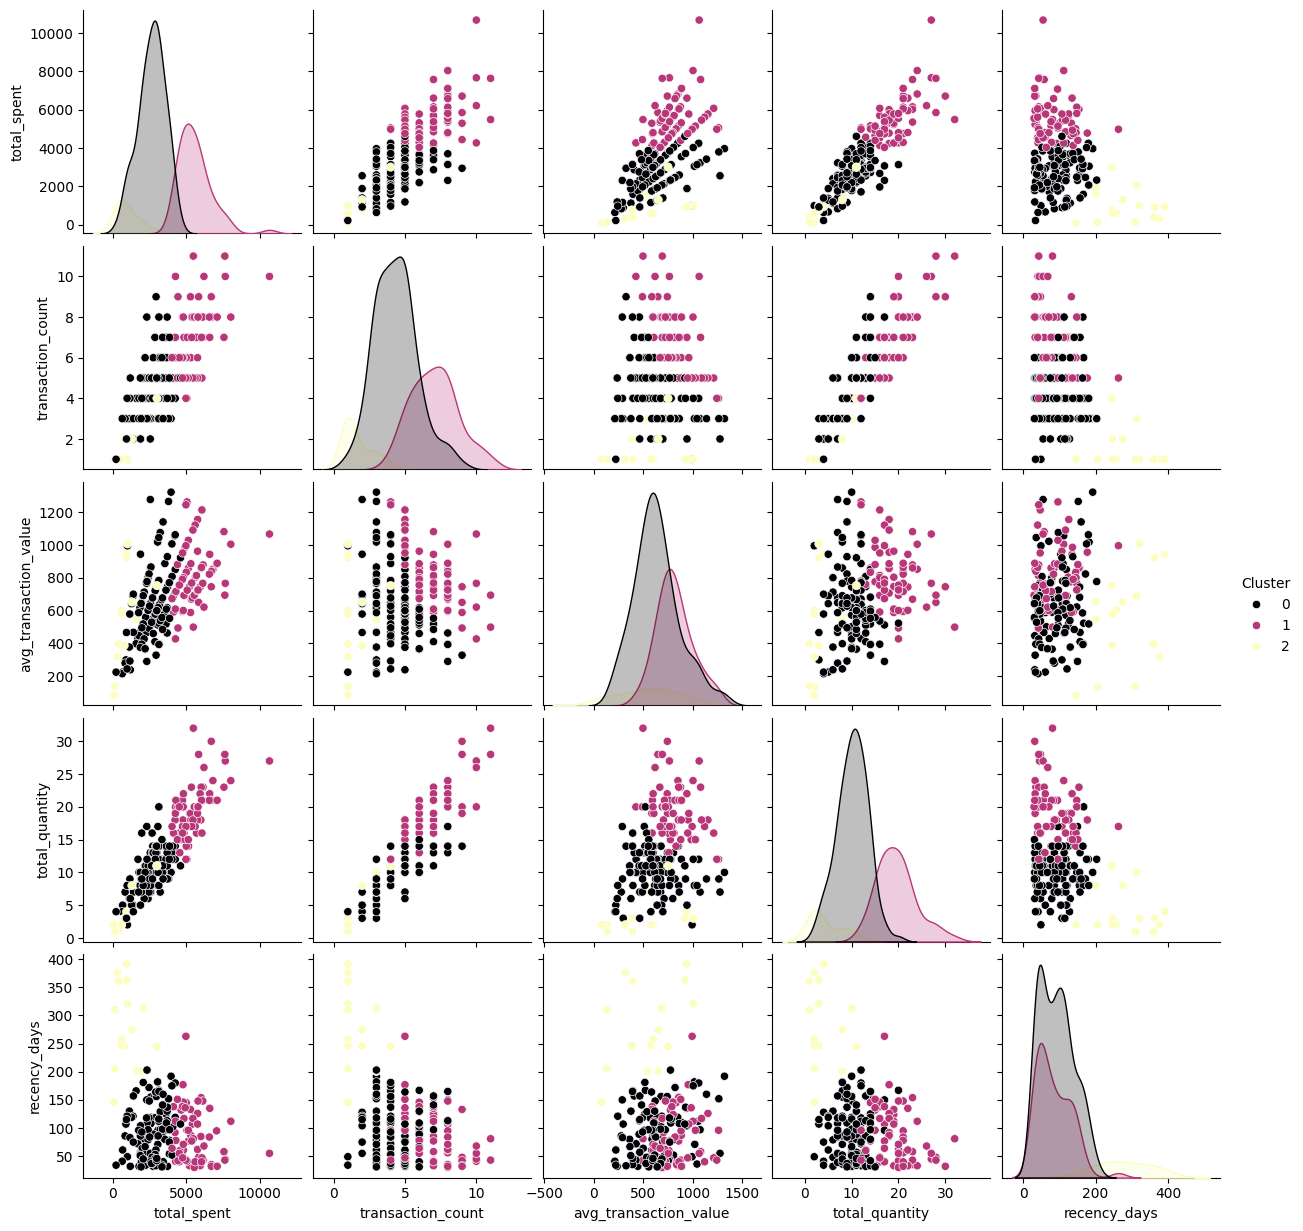

In [30]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)

sns.pairplot(customer_profile, hue='Cluster', vars=numeric_features, palette='magma')
plt.show()

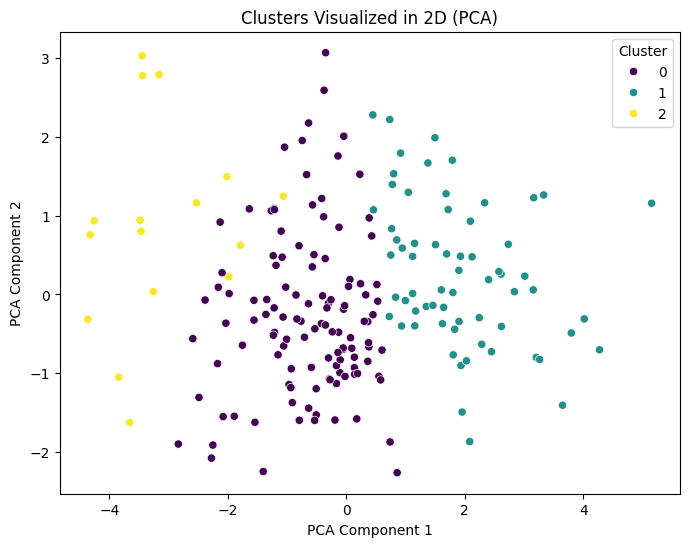

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

customer_profile['PCA1'] = reduced_data[:, 0]
customer_profile['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_profile['PCA1'],
    y=customer_profile['PCA2'],
    hue=customer_profile['Cluster'],
    palette="viridis",
    legend="full"
)
plt.title("Clusters Visualized in 2D (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

<Figure size 1000x600 with 0 Axes>

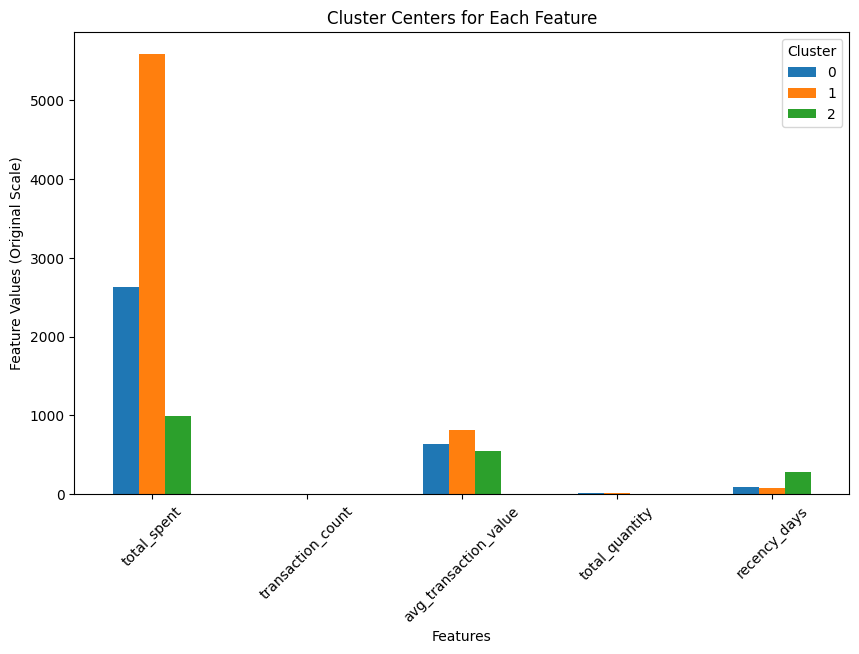

In [23]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numeric_features)

plt.figure(figsize=(10, 6))
cluster_centers_df.T.plot(kind='bar', figsize=(10, 6), legend=True)
plt.title("Cluster Centers for Each Feature")
plt.xticks(range(len(numeric_features)), numeric_features, rotation=45)
plt.ylabel("Feature Values (Original Scale)")
plt.xlabel("Features")
plt.legend(title="Cluster")
plt.show()

### INSIGHTS ON CLUSTERING

In [24]:
# Aggregate features
customer_features = data.groupby('CustomerID').agg({
    'Region': 'first',
    'SignupDate': 'first',
    'Quantity': 'sum',        # Total quantity purchased
    'TotalValue': 'sum',      # Total value of transactions
    'ProductID': 'nunique'    # Unique products purchased
}).reset_index()
customer_features

,CustomerID,Region,SignupDate,Quantity,TotalValue,ProductID
0,C0001,South America,2022-07-10,12,3354.52,5
1,C0002,Asia,2022-02-13,10,1862.74,4
2,C0003,South America,2024-03-07,14,2725.38,4
3,C0004,South America,2022-10-09,23,5354.88,8
4,C0005,Asia,2022-08-15,7,2034.24,3
...,...,...,...,...,...,...
194,C0196,Europe,2022-06-07,12,4982.88,3
195,C0197,Europe,2023-03-21,9,1928.65,3
196,C0198,Europe,2022-02-27,3,931.83,2
197,C0199,Europe,2022-12-03,9,1979.28,4


# Cluster Insights

### 1. Cluster :0
- **Spending**: Highest average spending (₹6075.93) and total spending.
- **Purchase Frequency**: Most frequent buyers (21.55 purchases on average).
- **Customer Lifetime**: Moderate tenure (1.80 years).
- **Insight**: These are **high-value customers** who frequently make large purchases. Likely to be your most profitable segment.

### 2. Cluster : 1
- **Spending**: Moderate average spending (₹3053.89).
- **Purchase Frequency**: Moderate purchase frequency (11.35 purchases).
- **Customer Lifetime**: Longest tenure (2.43 years).
- **Insight**: These are **loyal customers** who have been with the company for a long time but spend moderately.

### 3. Cluster : 2
- **Spending**: Moderate spending (₹3658.75).
- **Purchase Frequency**: Slightly higher than Cluster B (13.75 purchases).
- **Customer Lifetime**: Shortest tenure (0.69 years).
- **Insight**: These are **new customers** who show potential for growth, as their spending and frequency are already moderate despite their short tenure.

### 4. Cluster : 3 
- **Spending**: Lowest average spending (₹1498.85) and total spending.
- **Purchase Frequency**: Least frequent buyers (5.68 purchases).
- **Customer Lifetime**: Relatively short tenure (1.22 years).
- **Insight**: These are **low-value, infrequent buyers**. They may need targeted promotions or re-engagement strategies.
